# import

In [1]:
import sys
sys.path.append('../')

In [2]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import lightgbm as lgb
import pickle

from matplotlib.backends.backend_agg import FigureCanvasAgg
from PIL import Image

from pyvino.detector import DetectorHumanPose, DetectorBody
from actrec.util import moving_average, flatten_data, generate_col_names

/Users/yuya/anaconda3/envs/actrec/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


 # path

#movie_files = ['forehand.MOV', 'backhand.MOV', 'foreslice.MOV', 'backslice.MOV', 'test.MOV']
movie_files = ['forehand.mp4']

In [3]:
path_movie_dir = '../data/movie/fps30_mask/'
# path_movie_test_file = '../data/movie/test.MOV'

In [4]:
notebook_name = os.path.basename(os.getcwd())
timestamp = notebook_name.split('_')[1]
timestamp

'07'

In [5]:
path_generated_movie_dir = os.path.join('../data/08_PlotGraphMovie/', timestamp)
if not os.path.exists(path_generated_movie_dir):
    os.makedirs(path_generated_movie_dir)
path_save_file = os.path.join(path_generated_movie_dir, 'test_pred.mp4')

In [6]:
path_label_name_file = '../data/labels/labels_num.csv'
path_action_dir = os.path.join('../data/01_DataProcessing/', timestamp)
path_point_dir = os.path.join('../data/02_GetPoints/', timestamp)
path_split_dir = os.path.join('../data/04_Split/', timestamp)
path_test_file_dir = os.path.join(path_split_dir, 'test')
path_model_dir = os.path.join('../data/05_train/', timestamp)
path_model_file = os.path.join(path_model_dir, 'model.pkl')
path_pred_dir = os.path.join('../data/06_Evaluation/', timestamp)

In [33]:
file_names = ['forehand', 'backhand', 'foreslice', 'backslice', 'test']
# file_names = ['forehand']
movie_names = [file_name + '.mp4' for file_name in file_names]
points_file_names = [file_name + '.csv' for file_name in file_names]

In [34]:
objective_rev_dict = pd.read_csv(path_label_name_file).to_dict()['action_gt_name']

# model

In [35]:
det_b = DetectorBody()
det_h = DetectorHumanPose()

2019-09-15 22:56:45,703 - pyvino.detector.detector - INFO - person-detection-retail-0013 on Darwin
2019-09-15 22:56:45,704 - pyvino.detector.detector - INFO - The path to cpu_extension is /opt/intel/openvino/inference_engine/lib/intel64/libcpu_extension.dylib
2019-09-15 22:56:46,126 - pyvino.detector.detector - INFO - human-pose-estimation-0001 on Darwin
2019-09-15 22:56:46,127 - pyvino.detector.detector - INFO - The path to cpu_extension is /opt/intel/openvino/inference_engine/lib/intel64/libcpu_extension.dylib
2019-09-15 22:56:46,398 - pyvino.detector.detector - INFO - person-detection-retail-0013 on Darwin
2019-09-15 22:56:46,399 - pyvino.detector.detector - INFO - The path to cpu_extension is /opt/intel/openvino/inference_engine/lib/intel64/libcpu_extension.dylib


# data

# parameters

In [36]:
frame_length = 15

# process

## moving average

In [37]:
target_columns = ['RShoulder_x', 'RShoulder_y', 'RElbow_x', 'RElbow_y', 'RWrist_x', 'RWrist_y', 
                         'LShoulder_x', 'LShoulder_y', 'LElbow_x', 'LElbow_y', 'LWrist_x', 'LWrist_y']

## モデル読み込み

In [38]:
gbm = pickle.load(open(path_model_file, "rb"))
path_model_file

'../data/05_train/07/model.pkl'

In [39]:
feature_name_list = gbm.feature_name()

# 予測

In [40]:
mat = np.zeros(len(target_columns))
mat[:] = np.nan

In [68]:
num = 2
file_name = file_names[num]
movie_file = movie_names[num]
path_movie_test_file = os.path.join(path_movie_dir, movie_file)
path_movie_test_file

'../data/movie/fps30_mask/foreslice.mp4'

In [69]:
path_test_file = os.path.join(path_split_dir, 'test', file_name + '.csv')
path_test_file

'../data/04_Split/07/test/foreslice.csv'

In [70]:
objective = 'action_gt_num'
index_col = 'frame_num'

In [71]:
test_df = pd.read_csv(path_test_file, index_col=index_col).head()
frame_num = min(test_df.index)

- frame
- pred norm pose and generate frame
- preproce
- pred action
- draw result

In [72]:
cap = cv2.VideoCapture(path_movie_test_file)
# 幅
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
# 高さ
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
# 総フレーム数
count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
# fps
fps = int(cap.get(cv2.CAP_PROP_FPS))

canvas_org = np.zeros((height, width, 3), np.uint8)

In [73]:
features = []
for feature_name in feature_name_list:
    feature = feature_name.split('_')[0]
    features.append(feature)
features = list(np.unique(features))

In [74]:
test_df = pd.read_csv(path_test_file, index_col=index_col).head()
frame_num = min(test_df.index)
frame_num

3300

In [75]:
def queue(arr, arr_add):
    dst = np.vstack([arr, arr_add])
    dst = np.delete(dst, obj=0, axis=0)
    return dst

In [76]:
def queue_h(arr, arr_add):
    dst = np.hstack([arr, arr_add])
    dst = np.delete(dst, obj=0, axis=1)
    return dst

In [77]:
def plot_points(x, y, size=(12.8, 1)):
    fig = plt.figure(facecolor="black", figsize=size) #図の生成
    ax = fig.add_subplot(1,1,1) #軸の指定
    fig.tight_layout()
    
    fig.patch.set_facecolor('black')
    ax.patch.set_facecolor('black')

    plt.tick_params(labelbottom=False,
                                labelleft=False,
                                labelright=False,
                                labeltop=False)

    plt.tick_params(bottom=False,
                                left=False,
                                right=False,
                                top=False)

    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)

    ax.plot(x, y, c='pink') #データのプロット

    # ax.set_title('Graph',fontsize=24) #グラフのタイトル
    # ax.set_xlabel('x') #x軸の名前
    # ax.set_ylabel('y') #y軸の名前

    # ax.legend(loc='upper left', fontsize=20) #凡例の表示
    
    canvas = FigureCanvasAgg(fig)
    s, (width, height) = canvas.print_to_buffer()
    
    image = np.fromstring(s, np.uint8).reshape((height, width, 4))
    image = image[:,:,:3]
    
    return image

In [78]:
t = np.arange(-75, 75)

In [79]:
y = np.sin(t)

In [80]:
graph = plot_points(t, y)

/Users/yuya/anaconda3/envs/actrec/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app
/Users/yuya/anaconda3/envs/actrec/lib/python3.6/site-packages/ipykernel/__main__.py:35: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


In [81]:
height_graph, width_graph, _ = graph.shape

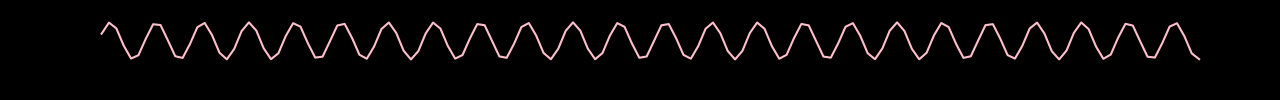

In [82]:
Image.fromarray(graph)

In [83]:
movie_file_name = '{}.mp4'.format(file_name)

In [84]:
color_codes = {'red' : (0,0,255),
                           'green' : (0,255,0),
                           'blue' : (255, 0,0),
                           'orange' : (255,127,80),
                           'skyblue' : (137,189,222)}

action_color = {'idle': 'green', 'forehand': 'red', 'backhand': 'blue', 'foreslice': 'orange', 'backslice': 'skyblue'}

In [89]:
path_generated_movie_dir

'../data/08_PlotGraphMovie/07'

In [90]:
show=True
width_movie = 1280
height_movie = 720
xmin_graph = int((width_movie - width_graph) / 2)
xmax_graph = int(width_graph + (width_movie - width_graph) / 2)
ymin_graph = int(height_movie - height_graph)
ymax_graph = int(height_movie)

fourcc = cv2.VideoWriter_fourcc(*"H264")
video = cv2.VideoWriter(os.path.join(path_generated_movie_dir, movie_file_name), fourcc, fps, (width_movie, height_movie))

# checker_df  = pd.DataFrame([], columns=feature_actions_df.columns)

test_df = pd.read_csv(path_test_file, index_col=index_col).head()
frame_num = min(test_df.index)
frame_num

window = 12
min_periods = 1

canvas_org = np.zeros((height, width, 3), np.uint8)

cap = cv2.VideoCapture(path_movie_test_file)

#####################
points_multi = np.empty((18, 2))
cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
points_flattens = np.zeros([30,len(target_columns)])
points_flattens[:,:] = np.nan
#####################

#####################
target_points = np.zeros([150, 2])
target_points[:,:] = np.nan
#####################

poss = np.empty((0, 4))

pred = True
while True:
    ret, frame = cap.read()
    if not ret:
        break
    if frame_num % 100 == 0:
        print(frame_num)
    
    frame = np.array(frame)
    frame = cv2.resize(frame, (width_movie, height_movie))

    ############################
    results = det_h.compute(frame, frame_flag=True, pred_flag=True, normalize_flag=True)
    frame = results['frame']
    ############################

    if len(results['preds']) == 0:
        points_flattens = np.vstack([points_flattens, mat])
        frame_num += 1
        video.write(frame)
        pred = False
        continue

    ############################
    points_dets = results['preds']
    new_area = 0
    largets_bbox_num = 0
    for num_det, points_det in points_dets.items():
        xmin, ymin, xmax, ymax = points_det['bbox']
        width = xmax - xmin
        height = ymax - ymin
        area = width * height
        if area > new_area:
            new_area = area
            largets_bbox_num = num_det
    ############################
    
    points = results['preds'][largets_bbox_num]['norm_points']
    points = pd.DataFrame(points, index=det_h.BODY_PARTS, columns=['x', 'y'])
    points = points.loc[features]
    points_flatten = points.values.flatten()
    points_flattens = queue(points_flattens, points_flatten)
    points_df = pd.DataFrame(points_flattens, columns=target_columns)
    # points_df = points_df.loc[:, target_columns]
    
    ############
    target_point = points.loc['RShoulder'].values
    target_points = queue(target_points, target_point)
    graph = plot_points(t, target_points.T[0])
    frame[ymin_graph:ymax_graph, xmin_graph:xmax_graph] = graph
    ############
    
    
    
    #  flatten
        
    ######
    # moving_average
    
    # frames to one columns
    #data_df = points_df.values.flatten()
    
    feature_actions_df = flatten_data(points_df)
    # sort features for model
    feature_actions_df = feature_actions_df.loc[:, feature_name_list]
    
    #checker_df = pd.concat([checker_df, feature_actions_df], axis=0)
    
    #  print(feature_actions_df)
    y_pred = gbm.predict(feature_actions_df, num_iteration=gbm.best_iteration)
    y_pred = np.argmax(y_pred, axis=1)[0]
    action_pred = objective_rev_dict[y_pred]
    pred = True

    ######    
    
    frame_num += 1
            
    cv2.rectangle(frame, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2)

    if pred:
        action_color_code = color_codes[action_color[action_pred]]
                
        cv2.putText(frame, 'pred: ' + action_pred,
                                (int(xmax), int(ymin - 10)),
                                cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255, 255, 255), 3, cv2.LINE_AA)
        
        cv2.putText(frame, 'pred: ' + action_pred,
                                (int(xmax), int(ymin - 10)),
                                cv2.FONT_HERSHEY_SIMPLEX, 1.2, action_color_code, 2, cv2.LINE_AA)

    video.write(frame)
    if show:
        cv2.imshow('demo', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

cap.release()
cv2.destroyAllWindows()

video.release()

3300


/Users/yuya/anaconda3/envs/actrec/lib/python3.6/site-packages/ipykernel/__main__.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  from ipykernel import kernelapp as app
/Users/yuya/anaconda3/envs/actrec/lib/python3.6/site-packages/ipykernel/__main__.py:35: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


3400
3500
3600
3700
3800
3900
4000
4100


In [91]:
video.release()

In [60]:
target_points

array([[       nan,        nan],
       [       nan,        nan],
       [       nan,        nan],
       [       nan,        nan],
       [       nan,        nan],
       [       nan,        nan],
       [       nan,        nan],
       [       nan,        nan],
       [       nan,        nan],
       [       nan,        nan],
       [       nan,        nan],
       [       nan,        nan],
       [       nan,        nan],
       [       nan,        nan],
       [       nan,        nan],
       [       nan,        nan],
       [       nan,        nan],
       [       nan,        nan],
       [       nan,        nan],
       [       nan,        nan],
       [       nan,        nan],
       [       nan,        nan],
       [       nan,        nan],
       [       nan,        nan],
       [       nan,        nan],
       [       nan,        nan],
       [       nan,        nan],
       [       nan,        nan],
       [       nan,        nan],
       [       nan,        nan],
       [  

In [105]:
points

,x,y
LElbow,0.507576,0.252396
LShoulder,0.166667,0.108626
LWrist,0.674242,0.178914
RElbow,0.507576,0.322684
RShoulder,0.333333,0.178914
RWrist,0.848485,0.252396


In [90]:
np.vstack([target_points, points_flatten])

array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [0.50757576, 0.25239617, 0.16666667, ..., 0.17891374, 0.84848485,
        0.25239617]])

In [86]:
target_points.shape

(150, 12)

In [87]:
points_flatten.reshape((12,1)).shape

(12, 1)

In [74]:
target_points

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [66]:
target_points.shape

(150, 12)

In [62]:
target_points.shape

(179, 12)